In [10]:
import numpy as np
import pandas as pd
import datetime as dt
import glob

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 8)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)


## Load an actigraphy file

In [2]:
devices = ['Actiwatch 2.0', 'Fitbit Charge 2 HR']
actfiles = ['/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/circadian_measures/raw/actiwatch/10011_act.txt',
         '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/circadian_measures/raw/fitbit/10011_fit.txt']

In [3]:
def read_actig(file): 
    # actigraphy input file is a file with two columns, Time ("%Y-%m-%d %H:%M:%S") and Activity, with no header
    
    data = pd.read_csv(file, sep = " ", header = None, names = ['time', 'activity'])
    data['time'] = data.values[:,0].astype(str)
    data['clocktime'] = [int(dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").time().strftime("%H")) + (int(dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").time().strftime("%M"))/60) for x in data['time']]
    data = data.groupby('clocktime').max()
    data['lmaxact'] = np.log10(data['activity'] + 1)
    return data

In [4]:
act = read_actig(actfiles[0])
fit = read_actig(actfiles[1])
fitInt = read_actig('/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/fitbit/interpolated/WA_10011_interpolated_mean.txt')

In [5]:
x_act = act.index.values
y_act = act['lmaxact'].values

x_fit = fit.index.values
y_fit = fit['lmaxact'].values

x_fitInt = fitInt.index.values
y_fitInt = fitInt['lmaxact'].values

## Pre-processing

In [6]:
print('Total number of missing values: %.f' %(act['activity'].isna().sum()))
print('Total number of missing values: %.f' %(fit['activity'].isna().sum()))

Total number of missing values: 0
Total number of missing values: 0


In [23]:
hrfile = glob.glob('/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/fitbit/WA_10011_heartrate_1min*.csv')
hrfile[0]

'/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/fitbit/WA_10011_heartrate_1min_20190711_20200811.csv'

In [24]:
hr = pd.read_csv(hrfile[0])
hr['Time'] = pd.to_datetime(hr['Time'])
hr = hr.set_index('Time')


fitn = pd.read_csv('/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/circadian_measures/raw/fitbit/10011_fit.txt', sep = " ", names = ['Time', 'Activity'])
fitn['Time'] = pd.to_datetime(fitn['Time'])
fitn = fitn.set_index('Time')

hr = hr.join(fitn, lsuffix = '_hr', rsuffix = '_fit')
print('Total number of missing values: %.f' %(hr['Activity'].isna().sum()))

Total number of missing values: 12


In [25]:
hr

,Value,Activity
Time,,
2019-10-24 16:18:00,56,NaN
2019-10-24 16:19:00,58,NaN
2019-10-24 16:20:00,55,NaN
2019-10-24 16:21:00,55,NaN
2019-10-24 16:22:00,57,NaN
...,...,...
2019-11-07 15:53:00,74,35.0
2019-11-07 15:54:00,75,0.0
2019-11-07 15:55:00,73,0.0


Here showing way more missing values compared to R

In [26]:
missing = hr[hr['Activity'].isna()].index.values
missing

array(['2019-10-24T16:18:00.000000000', '2019-10-24T16:19:00.000000000',
       '2019-10-24T16:20:00.000000000', '2019-10-24T16:21:00.000000000',
       '2019-10-24T16:22:00.000000000', '2019-10-24T16:23:00.000000000',
       '2019-10-24T16:24:00.000000000', '2019-10-24T16:25:00.000000000',
       '2019-10-24T16:26:00.000000000', '2019-10-24T16:27:00.000000000',
       '2019-10-24T16:28:00.000000000', '2019-10-24T16:29:00.000000000'],
      dtype='datetime64[ns]')

In [27]:
len(missing)

12

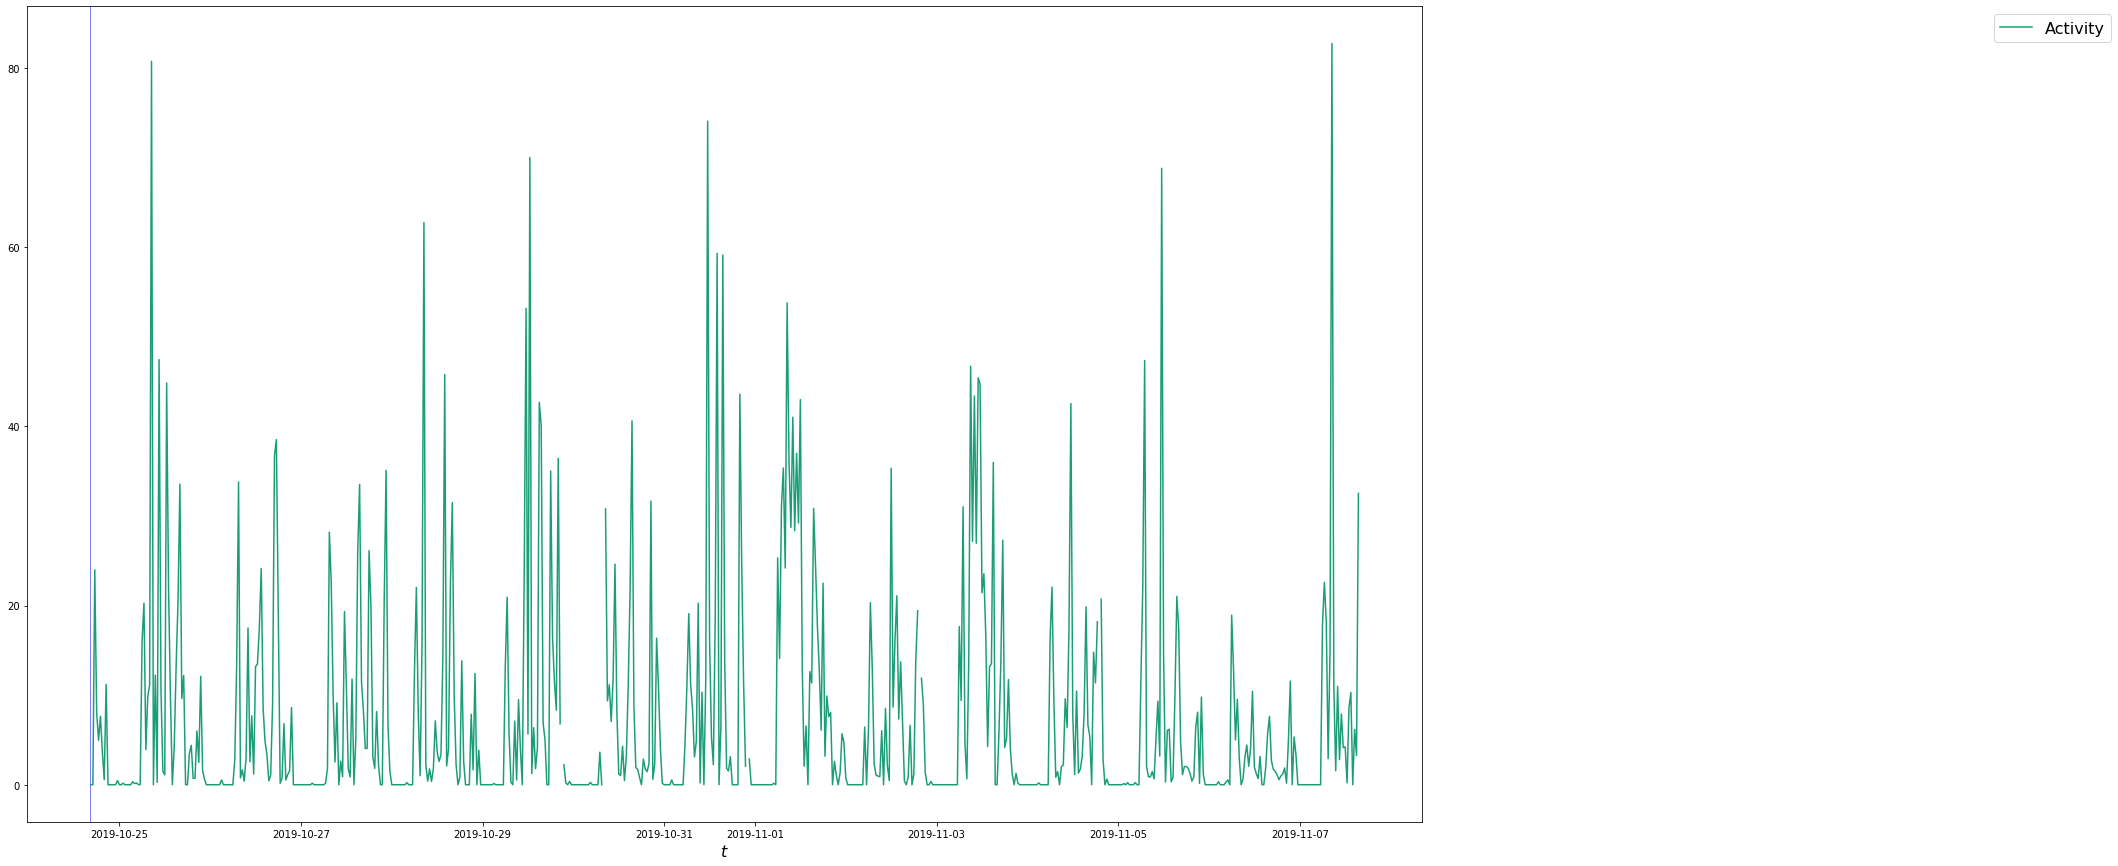

In [28]:
hrn = hr.resample('30min').mean()
plt.figure(figsize = (25, 15))
#plt.plot(hrn.index, hrn.Value, label='Heart Rate')
plt.plot(hrn.index, hrn.Activity, label='Activity')
for i in range(0,len(missing)-1):
    plt.axvspan(missing[i], missing[i+1], facecolor='b', alpha=0.5)
plt.xlabel('$t$')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1)

## Cosinor analysis

In [29]:
def hillfx(t, actmin, amp, phi, m, g):
    # takes 3 x: min, amp, m
    c = abs(np.cos((t - phi) * (2*np.pi/24)))
    return actmin + amp*(((c+1)**g )/( m**g + (c+1)**g ))


def antilogfx(t, actmin, amp, alpha, beta, phi):
    # takes 5 x: min, amp, alpha, beta, phi
    c = np.cos((t - phi) * (2*np.pi/24))
    return actmin + amp*((np.exp(beta * (c - alpha)))/(1 + np.exp(beta * (c - alpha))))


def arctanfx(t, actmin, amp, alpha, beta, phi):
    # takes 5 x: min, amp, alpha, beta, phi
    c = np.cos((t - phi) * (2*np.pi/24))
    return actmin + amp*(np.arctan(beta * (c - alpha))/(np.pi + (1/2)))


In [30]:
from scipy.optimize import curve_fit
from scipy.optimize import Bounds

In [31]:
hill_act, hill_act_cov = curve_fit(hillfx, xdata = x_act, ydata = y_act)
hill_fit, hill_fit_cov = curve_fit(hillfx, xdata = x_fit, ydata = y_fit)

print('Actiwatch Hill cosinor model parameter estimates:\n min: %.2f\n amp: %.2f\n phi: %.2f\n m: %.2f\n g: %.2f\n' % 
      (hill_act[0], hill_act[1], hill_act[2], hill_act[3], hill_act[4]))

print('Fitbit Hill cosinor model parameter estimates:\n min: %.2f\n amp: %.2f\n phi: %.2f\n m: %.2f\n g: %.2f\n' % 
      (hill_fit[0], hill_fit[1], hill_fit[2], hill_fit[3], hill_fit[4]))


Actiwatch Hill cosinor model parameter estimates:
 min: 2.33
 amp: 0.59
 phi: -15.19
 m: 1.63
 g: 23.81

Fitbit Hill cosinor model parameter estimates:
 min: 0.90
 amp: 0.75
 phi: 2.60
 m: 1.67
 g: -26.84



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [32]:
bounds = ([0, 0, -np.inf, 0, 0], [2, 2, np.inf, np.inf, 24])

In [33]:
antilog_act, antilog_act_cov = curve_fit(antilogfx, xdata = x_act, ydata = y_act, bounds = bounds)
antilog_fit, antilog_fit_cov = curve_fit(antilogfx, xdata = x_fit, ydata = y_fit, bounds = bounds)
antilog_fitInt, antilog_fitInt_cov = curve_fit(antilogfx, xdata = x_fitInt, ydata = y_fitInt, bounds = bounds)

print('Actiwatch Antilogarithmic cosinor model parameter estimates:\n min: %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (antilog_act[0], antilog_act[1], antilog_act[2], antilog_act[3], antilog_act[4]))

print('Fitbit Antilogarithmic cosinor model parameter estimates:\n min: %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (antilog_fit[0], antilog_fit[1], antilog_fit[2], antilog_fit[3], antilog_fit[4]))

print('Fitbit Interpolated Antilogarithmic cosinor model parameter estimates:\n min: %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (antilog_fitInt[0], antilog_fitInt[1], antilog_fitInt[2], antilog_fitInt[3], antilog_fitInt[4]))


Actiwatch Antilogarithmic cosinor model parameter estimates:
 min: 1.60
 amp: 1.35
 alpha: -0.77
 beta 13.89
 phi: 14.74
Fitbit Antilogarithmic cosinor model parameter estimates:
 min: 0.05
 amp: 1.67
 alpha: -0.63
 beta 14.48
 phi: 14.41
Fitbit Interpolated Antilogarithmic cosinor model parameter estimates:
 min: 0.05
 amp: 1.68
 alpha: -0.65
 beta 16.10
 phi: 14.52


In [34]:
antilog_act[None]

array([[ 1.59784582,  1.34907229, -0.77169917, 13.89295938, 14.73995808]])

In [35]:
fitdf = pd.DataFrame(antilog_act[None], columns =  [['actmin', 'amp', 'alpha', 'beta', 'phi']])
fitdf

,actmin,amp,alpha,beta,phi
0,1.597846,1.349072,-0.771699,13.892959,14.739958


In [36]:
arctan_act, arctan_act_cov = curve_fit(arctanfx, xdata = x_act, ydata = y_act, bounds = bounds)
arctan_fit, arctan_fit_cov = curve_fit(arctanfx, xdata = x_fit, ydata = y_fit, bounds = bounds)
arctan_fitInt, arctan_fitInt_cov = curve_fit(arctanfx, xdata = x_fitInt, ydata = y_fitInt, bounds = bounds)

print('Actiwatch Arctangent cosinor model parameter estimates: min:\n %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (arctan_act[0], arctan_act[1], arctan_act[2], arctan_act[3], arctan_act[4]))

print('Fitbit Arctangent cosinor model parameter estimates:\n min:\n %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (arctan_fit[0], arctan_fit[1], arctan_fit[2], arctan_fit[3], arctan_fit[4]))

print('Fitbit Interpolated Arctangent cosinor model parameter estimates:\n min:\n %.2f\n amp: %.2f\n alpha: %.2f\n beta %.2f\n phi: %.2f' % 
      (arctan_fitInt[0], arctan_fitInt[1], arctan_fitInt[2], arctan_fitInt[3], arctan_fitInt[4]))


Actiwatch Arctangent cosinor model parameter estimates: min:
 2.00
 amp: 2.00
 alpha: -0.87
 beta 10.67
 phi: 14.62
Fitbit Arctangent cosinor model parameter estimates:
 min:
 0.89
 amp: 1.99
 alpha: -0.62
 beta 22.27
 phi: 14.40
Fitbit Interpolated Arctangent cosinor model parameter estimates:
 min:
 0.89
 amp: 2.00
 alpha: -0.64
 beta 19.70
 phi: 14.53


Compute predictions with found parameters:

In [37]:
y_act_hill = hillfx(x_act, *hill_act)
y_fit_hill = hillfx(x_fit, *hill_fit)

y_act_antilog = antilogfx(x_act, *antilog_act)
y_fit_antilog = antilogfx(x_fit, *antilog_fit)
y_fitInt_antilog = antilogfx(x_fitInt, *antilog_fit)

y_act_arctan = arctanfx(x_act, *arctan_act)
y_fit_arctan = arctanfx(x_fit, *arctan_fit)
y_fitInt_arctan = arctanfx(x_fitInt, *arctan_fit)

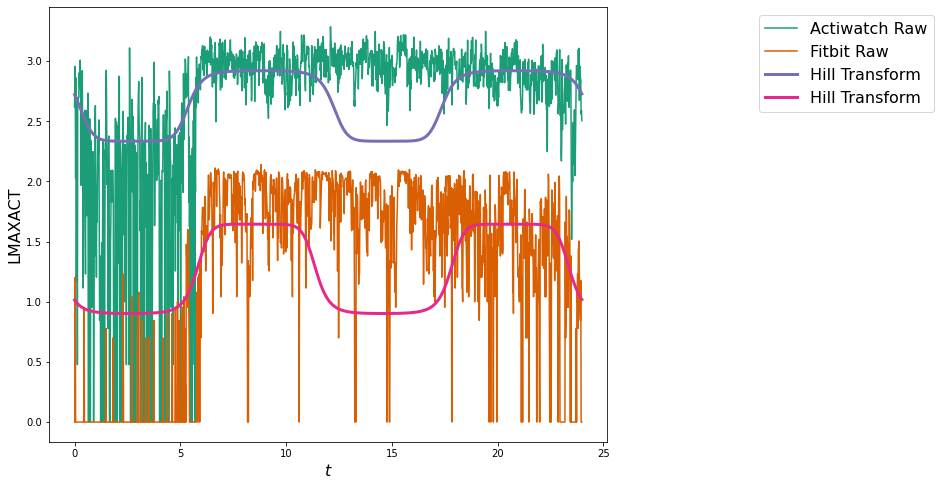

In [38]:
plt.plot(x_act, y_act, label='Actiwatch Raw')
plt.plot(x_fit, y_fit, label='Fitbit Raw')
plt.plot(x_act, y_act_hill, label='Hill Transform', linewidth = 3)
plt.plot(x_fit, y_fit_hill, label='Hill Transform', linewidth = 3)
plt.xlabel('$t$')
plt.ylabel('LMAXACT')
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)

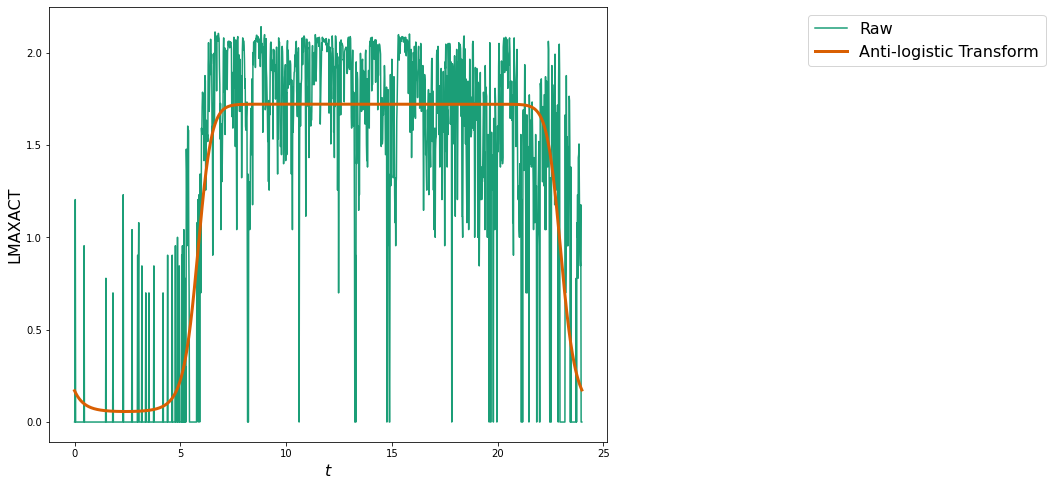

In [42]:
#plt.plot(x_act, y_act, label='Actiwatch Raw')
plt.plot(x_fit, y_fit, label='Raw')
#plt.plot(x_fitInt, y_fitInt, label='Fitbit Interpolated')
#plt.plot(x_act, y_act_antilog, label='Anti-logistic Transform', linewidth = 3)
#plt.plot(x_fit, y_fit_antilog, label='Anti-logistic Transform', linewidth = 3)
plt.plot(x_fit, y_fitInt_antilog, label='Anti-logistic Transform', linewidth = 3)

plt.xlabel('$t$')
plt.ylabel('LMAXACT')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', ncol=1)

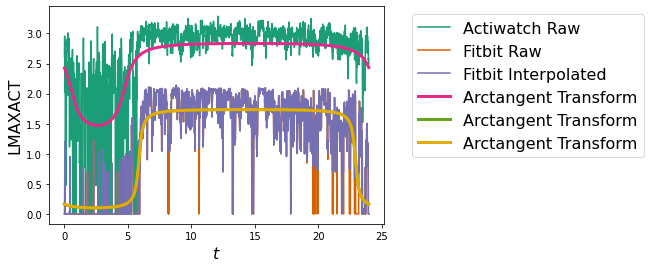

In [23]:
plt.plot(x_act, y_act, label='Actiwatch Raw')
plt.plot(x_fit, y_fit, label='Fitbit Raw')
plt.plot(x_fit, y_fitInt, label='Fitbit Interpolated')
plt.plot(x_act, y_act_arctan, label='Arctangent Transform', linewidth = 3)
plt.plot(x_fit, y_fit_arctan, label='Arctangent Transform', linewidth = 3)
plt.plot(x_fit, y_fitInt_arctan, label='Arctangent Transform', linewidth = 3)
plt.xlabel('$t$')
plt.ylabel('LMAXACT')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', ncol=1)

-----------------

## How do these metrics compare to Stephanie's?

In [24]:
cr = pd.read_csv('/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/circadian_measures/7_days/cosinor_7days_act.csv')
cr[cr['record_id'] == 10011][['actmin', 'actamp', 'actalph', 'actbeta', 'actphi']]

,actmin,actamp,actalph,actbeta,actphi
0,0.209635,1.767917,-0.507228,9.928749,14.542104


In [25]:
cr = pd.read_csv('/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/circadian_measures/7_days/cosinor_7days_fit.csv')
cr[cr['record_id'] == 10011][['actmin', 'actamp', 'actalph', 'actbeta', 'actphi']]

,actmin,actamp,actalph,actbeta,actphi
0,0.0,1.0,0.9133,1.229752,11.728705


In [27]:
y_act_ss = antilogfx(x_act, 0.209635, 1.767917, -0.507228, 9.928749, 14.542104)
y_fit_ss = antilogfx(x_fit, 0.0, 1.0, 0.9133, 1.229752, 11.728705)

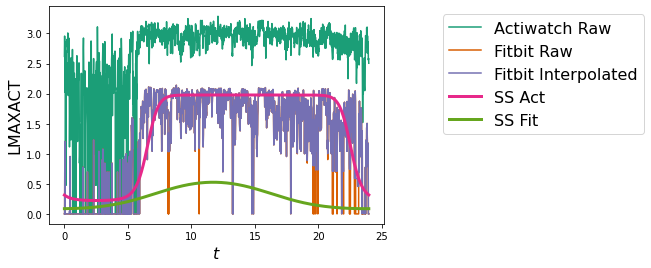

In [28]:
plt.plot(x_act, y_act, label='Actiwatch Raw')
plt.plot(x_fit, y_fit, label='Fitbit Raw')
plt.plot(x_fitInt, y_fitInt, label='Fitbit Interpolated')
plt.plot(x_act, y_act_ss, label='SS Act', linewidth = 3)
plt.plot(x_fit, y_fit_ss, label='SS Fit', linewidth = 3)
plt.xlabel('$t$')
plt.ylabel('LMAXACT')
plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', ncol=1)